# Build temporal network of PPI with gene expression data from RNA-seq

Here, we build a temporal network of protein-protein interactions (PPI) for the cell cycle of budding yeast, by integrating time series data about gene expression to a static network of PPI.

In [1]:
import string

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb

import phasik as pk

outdir = "../data/kelliher"
figdir = "images/kelliher"

## 1. Load static network

In [2]:
static_net_filepath = "../data/kegg/static_PPI_network_KEGG.adjlist"
static_network = nx.read_adjlist(static_net_filepath)

pk.graph_size_info(static_network)

'83 nodes and 159 edges'

In [3]:
# change names to match those in gene expression data
names_to_replace = {
    "APC": "CDC27",
    "SCF": "CDC53",
    "PP2A": "TPD3",
    "ORC": "ORC2",
    "MCM": "MCM2",
    "DDC2": "LCD1",
}

static_network = nx.relabel_nodes(static_network, names_to_replace)

## 2. Load and format temporal data

### 2.1 Visualise all time points

In [4]:
edge_table_filepath = "../data_raw/kelliher/GSE80474_Scerevisiae_normalized.txt"

node_series = pd.read_csv(
    edge_table_filepath, sep="\t", index_col="time_points"
)  # , skipfooter=1, engine='python')

# uncomment if we want only the first i_end timepoints
# i_start = 3
# i_end = 23
# node_series = node_series.iloc[:, i_start:i_end]

n_times = node_series.shape[1]
times_full = node_series.columns.astype(int).to_numpy()
t_step = np.diff(times_full)[0]  # 5 min

n_points_per_cycle = 15
# sampling_frequency = 5 # min

times = times_full  # np.arange(n_times) * sampling_frequency
node_series.columns = times

# node_series.columns = ['ID'] + times.tolist()

node_series

0       5      10      15      20      25      30      35   \
time_points                                                                  
15S_rRNA      1.000   1.000  1.000   1.000   1.000   1.000   1.000   1.000   
21S_rRNA      1.000   1.000  1.000   1.000   1.000   1.000   1.000   1.000   
HRA1          1.853   1.332  1.533   1.381   1.199   1.000   1.000   1.000   
ICR1          6.440   7.334  4.252   4.448   4.905   6.976   6.323   6.342   
LSR1         16.821  14.167  8.903  23.702  22.792  29.675  22.024  44.021   
...             ...     ...    ...     ...     ...     ...     ...     ...   
ARR3          2.747   3.068  3.783   3.309   3.980   3.451   2.948   3.582   
YPR202W       1.599   2.630  1.249   2.338   2.817   2.779   1.814   1.937   
YPR203W       1.000   1.000  1.000   1.000   1.000   1.000   1.000   1.000   
YPR204C-A     1.000   1.000  1.000   1.000   1.000   1.000   1.000   1.000   
YPR204W       1.133   1.206  1.221   1.498   1.471   1.631   1.557   1.380   

               40     45   ...    200     205     210     215     220     225  \
time_points                ...                                                  
15S_rRNA     1.000  1.000  ...  1.000   1.000   1.000   1.000   1.000   1.000   
21S_rRNA     1.000  1.000  ...  1.000   1.000   1.000   1.000   1.000   1.000   
HRA1         1.000  1.159  ...  1.180   1.672   1.346   1.181   1.157   1.337   
ICR1         5.770  6.511  ...  6.559   6.989   7.156   6.804   7.646   9.093   
LSR1         8.011  7.492  ...  8.157  10.105  26.766  12.075  11.775  21.421   
...            ...    ...  ...    ...     ...     ...     ...     ...     ...   
ARR3         3.853  4.118  ...  2.863   4.055   3.715   3.514   2.958   3.699   
YPR202W      2.686  1.893  ...  1.380   1.472   1.243   1.254   1.441   1.118   
YPR203W      1.000  1.000  ...  1.000   1.000   1.000   1.000   1.000   1.000   
YPR204C-A    1.000  1.000  ...  1.000   1.000   1.000   1.000   1.000   1.000   
YPR204W      1.359  1.099  ...  1.337   1.209   1.151   1.045   1.293   1.272   

                230     235     240     245  
time_points                                  
15S_rRNA      1.000   1.000   1.000   1.000  
21S_rRNA      1.000   1.000   1.000   1.000  
HRA1          1.163   1.136   1.466   1.147  
ICR1          9.368   8.558   8.830   7.341  
LSR1         27.191  16.976  14.725  13.356  
...             ...     ...     ...     ...  
ARR3          4.086   3.379   3.105   3.666  
YPR202W       1.344   1.670   1.873   1.206  
YPR203W       1.000   1.000   1.000   1.000  
YPR204C-A     1.000   1.000   1.000   1.000  
YPR204W       1.183   1.339   1.426   1.310  

[7126 rows x 50 columns]

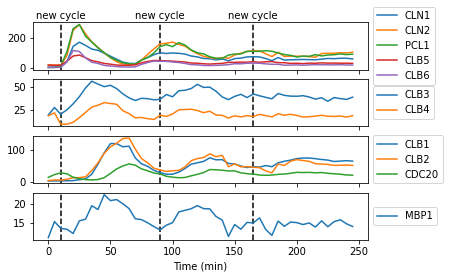

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)

data = pk.TemporalData.from_df(node_series.transpose(), times=times, true_times=times)

data.plot_series(["CLN1", "CLN2", "PCL1", "CLB5", "CLB6"], add_labels=False, ax=ax1)
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plot_new_events(ax=ax1, labels=True, ypos=500)

data.plot_series(["CLB3", "CLB4"], add_labels=False, ax=ax2)
ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plot_new_events(ax=ax2, labels=False)

data.plot_series(["CLB1", "CLB2", "CDC20"], add_labels=False, ax=ax3)
ax3.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plot_new_events(ax=ax3, labels=False)


data.plot_series(["MBP1"], add_labels=False, ax=ax4)
ax4.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plot_new_events(ax=ax4, labels=False)

# time_ticks = np.arange(0, 50, 7.5)
# time_ticks = range(0, 101, 10)
# ax4.set_xticks(time_ticks)
# ax4.set_xlabel("Timepoints (5 min)")
ax4.set_xlabel("Time (min)")

# values from Kelliher et al. paper
dt = 10
new_cycle_1 = 20 - dt
new_cycle_2 = 100 - dt
new_cycle_3 = 175 - dt

for i, ax in enumerate(fig.axes):
    ax.axvline(new_cycle_1, c="k", ls="--", zorder=-2)
    ax.axvline(new_cycle_2, c="k", ls="--", zorder=-2)
    ax.axvline(new_cycle_3, c="k", ls="--", zorder=-2)
    if i == 0:
        ax.text(new_cycle_1, 350, "new cycle", rotation=0, va="center", ha="center")
        ax.text(new_cycle_2, 350, "new cycle", rotation=0, va="center", ha="center")
        ax.text(new_cycle_3, 350, "new cycle", rotation=0, va="center", ha="center")

# plt.savefig(f"{figdir}/kelliher_timeseries_full.png", dpi=250, bbox_inches="tight")

plt.show()

### 2.2 Restrict to 1st full cycle

In [6]:
edge_table_filepath = "../data_raw/kelliher/GSE80474_Scerevisiae_normalized.txt"

node_series = pd.read_csv(
    edge_table_filepath, sep="\t", index_col="time_points"
)  # , skipfooter=1, engine='python')

# uncomment if we want only the first i_end timepoints
i_start = times_full.tolist().index(new_cycle_1)  # = 4
i_end = times_full.tolist().index(new_cycle_2)  # = 20
node_series = node_series.iloc[:, i_start:i_end]

n_times = node_series.shape[1]
true_times = node_series.columns.astype(int).to_numpy()

n_points_per_cycle = 15

times = true_times - true_times[0]  # np.arange(n_times) * sampling_frequency
node_series.columns = times

# node_series.columns = ['ID'] + times.tolist()

node_series

0       5       10      15      20      25     30     35  \
time_points                                                                
15S_rRNA     1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
21S_rRNA     1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
HRA1         1.533   1.381   1.199   1.000   1.000   1.000  1.000  1.159   
ICR1         4.252   4.448   4.905   6.976   6.323   6.342  5.770  6.511   
LSR1         8.903  23.702  22.792  29.675  22.024  44.021  8.011  7.492   
...            ...     ...     ...     ...     ...     ...    ...    ...   
ARR3         3.783   3.309   3.980   3.451   2.948   3.582  3.853  4.118   
YPR202W      1.249   2.338   2.817   2.779   1.814   1.937  2.686  1.893   
YPR203W      1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
YPR204C-A    1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
YPR204W      1.221   1.498   1.471   1.631   1.557   1.380  1.359  1.099   

                 40     45      50      55      60     65     70     75  
time_points                                                              
15S_rRNA      1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
21S_rRNA      1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
HRA1          1.362  1.668   1.171   1.000   1.000  1.000  1.299  1.000  
ICR1          5.972  5.957   5.206   6.427   8.070  9.647  9.703  8.320  
LSR1         10.609  9.735  12.841  15.096  21.682  8.668  7.543  8.297  
...             ...    ...     ...     ...     ...    ...    ...    ...  
ARR3          4.033  3.678   3.737   4.083   3.458  4.044  3.503  2.960  
YPR202W       1.763  1.352   1.599   2.321   2.178  2.935  1.944  1.585  
YPR203W       1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
YPR204C-A     1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
YPR204W       1.158  1.333   1.276   1.328   1.302  1.514  1.484  1.622  

[7126 rows x 16 columns]

In [7]:
# determine events for plots below
data = pk.TemporalData.from_df(node_series.transpose(), times=times, true_times=times)

id_mbp1_max = np.argmax(data.series("MBP1"))
id_clb2_max = np.argmax(data.series("CLB2"))
id_clb1_max = np.argmax(data.series("CLB1"))

events_times = [
    0,
    times[id_mbp1_max],
    times[id_clb1_max],
    times[id_clb2_max],
    75,
]
events_labels = [
    "new cycle",
    "MBP1 max.",
    "CLB1 max.",
    "CLB2 max.",
    "new cycle",
]

events = [(time, name, "dashed") for time, name in zip(events_times, events_labels)]

phases = [
    (0, 5 + dt, "G1"),
    (5 + dt, 25 + dt, "S"),
    (25 + dt, 40 + dt, "G2"),
    (40 + dt, 75, "M"),
]

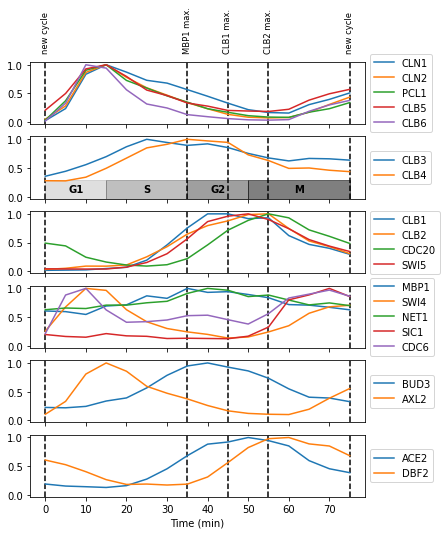

In [8]:
# plot time series

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(
    6, 1, sharex=True, sharey=True, figsize=(6, 8)
)

data.plot_series(
    ["CLN1", "CLN2", "PCL1", "CLB5", "CLB6"],
    add_labels=False,
    ax=ax1,
    norm=True,
)
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
pk.plot_events(events, ax=ax1, text_y_pos=1.2, text_x_offset=0)

data.plot_series(["CLB3", "CLB4"], add_labels=False, ax=ax2, norm=True)
ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5))
pk.plot_events(events, ax=ax2, add_labels=False)

data.plot_series(["CLB1", "CLB2", "CDC20", "SWI5"], add_labels=False, ax=ax3, norm=True)
ax3.legend(loc="center left", bbox_to_anchor=(1, 0.5))
pk.plot_events(events, ax=ax3, add_labels=False)

data.plot_series(
    ["MBP1", "SWI4", "NET1", "SIC1", "CDC6"],
    add_labels=False,
    ax=ax4,
    norm=True,
)
ax4.legend(loc="center left", bbox_to_anchor=(1, 0.5))
pk.plot_events(events, ax=ax4, add_labels=False)
pk.plot_phases(phases, ax=ax2, y_pos=0.15, ymax=0.3)

data.plot_series(["BUD3", "AXL2"], add_labels=False, ax=ax5, norm=True)
ax5.legend(loc="center left", bbox_to_anchor=(1, 0.5))
pk.plot_events(events, ax=ax5, add_labels=False)

data.plot_series(["ACE2", "DBF2"], add_labels=False, ax=ax6, norm=True)
ax6.legend(loc="center left", bbox_to_anchor=(1, 0.5))
pk.plot_events(events, ax=ax6, add_labels=False)

ax6.set_xlabel("Time (min)")

# plt.savefig(f"{figdir}/kelliher_timeseries.png", dpi=250, bbox_inches="tight")
# plt.savefig(f"{figdir}/kelliher_timeseries.svg", dpi=250, bbox_inches="tight")

plt.show()

### 2.3 Format

In [9]:
# deal with potential ducplicate gene names (different affymatrix ids correspond to a single gene name)
node_series_formatted = node_series.transpose()
node_series_formatted.head()

# find duplicate nodes
mask = node_series_formatted.columns.duplicated()
duplicate_nodes = node_series_formatted.columns[mask].unique()  # in the node_series
duplicates_in_static_network = set(static_network.nodes).intersection(
    duplicate_nodes
)  # also in the static net
print(
    "More than one time series correspond to the following nodes of the static network (genes):"
)
print(f"{duplicates_in_static_network}")

# choose method to combine gene ids
combine_duplicates = "average"  # can also be 'first', 'last'

if combine_duplicates == "average":
    # replace duplicate gene columns by their average
    node_series = node_series_formatted.groupby(level=0, axis=1, sort=False).mean()
elif combine_duplicates == "first":
    # replace duplicate gene columns by the first time series
    node_series = node_series_formatted.groupby(level=0, axis=1, sort=False).first()
elif combine_duplicates == "last":
    # replace duplicate gene columns by the first time series
    node_series = node_series_formatted.groupby(level=0, axis=1, sort=False).last()
else:
    print("WARNING: method of combining duplicates not supported")

node_series = node_series.T

More than one time series correspond to the following nodes of the static network (genes):
set()


In [10]:
node_series

0       5       10      15      20      25     30     35  \
time_points                                                                
15S_rRNA     1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
21S_rRNA     1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
HRA1         1.533   1.381   1.199   1.000   1.000   1.000  1.000  1.159   
ICR1         4.252   4.448   4.905   6.976   6.323   6.342  5.770  6.511   
LSR1         8.903  23.702  22.792  29.675  22.024  44.021  8.011  7.492   
...            ...     ...     ...     ...     ...     ...    ...    ...   
ARR3         3.783   3.309   3.980   3.451   2.948   3.582  3.853  4.118   
YPR202W      1.249   2.338   2.817   2.779   1.814   1.937  2.686  1.893   
YPR203W      1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
YPR204C-A    1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
YPR204W      1.221   1.498   1.471   1.631   1.557   1.380  1.359  1.099   

                 40     45      50      55      60     65     70     75  
time_points                                                              
15S_rRNA      1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
21S_rRNA      1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
HRA1          1.362  1.668   1.171   1.000   1.000  1.000  1.299  1.000  
ICR1          5.972  5.957   5.206   6.427   8.070  9.647  9.703  8.320  
LSR1         10.609  9.735  12.841  15.096  21.682  8.668  7.543  8.297  
...             ...    ...     ...     ...     ...    ...    ...    ...  
ARR3          4.033  3.678   3.737   4.083   3.458  4.044  3.503  2.960  
YPR202W       1.763  1.352   1.599   2.321   2.178  2.935  1.944  1.585  
YPR203W       1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
YPR204C-A     1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
YPR204W       1.158  1.333   1.276   1.328   1.302  1.514  1.484  1.622  

[7126 rows x 16 columns]

## 3. Build temporal network

In [11]:
# build temporal network
temporal_network = pk.TemporalNetwork.from_static_network_and_node_timeseries(
    static_network,
    node_series,
    combine_node_weights=lambda x, y: x * y,
    static_edge_default_weight=1,
    normalise="max",
    quiet=False,
)

temporal_network_name = f"kegg_kelliher"

A PartiallyTemporalNetwork is created instead.
Edges with no temporal information:
{('Cohesin', 'ESP1')}


In [12]:
print(temporal_network)

<class 'phasik.classes.PartiallyTemporalNetwork.PartiallyTemporalNetwork'> with 83 nodes and 16 times
